In [1]:
import pandas as pd
import numpy as np
import pickle
from StringContains import ContainedStringCase 
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import os
from scipy.stats import ks_2samp, ttest_rel, f, mannwhitneyu, pearsonr, spearmanr, kendalltau
from jmh_parser import parseFile
from benchmarkutils import get_data_frame_from_csv, get_ks_2sample_test_log, get_mann_whitney_u_test_test_log, read_log
from statsmodels.formula.api import ols
import statsmodels.api as sm
import glob
import math

In [2]:
output_dir = "http_singleStrings/"
df = pd.read_csv(output_dir + "http_8_1_9.csv")
files = glob.glob(output_dir + "*[0-9].csv", recursive=False)
print(len(files))
df

1051


,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: regex,Param: str
0,benchmark.StringContains.regexMatches,avgt,1,100,97.106292,0.184889,ns/op,http,"/.R""iu.9"
1,benchmark.StringContains.stringContains,avgt,1,100,8.974715,0.006571,ns/op,http,"/.R""iu.9"


In [66]:
def getStd(file_path):
    t = parseFile(file_path)
    t = t.loc[t["Iteration Type"]=="measured",:]
    t = t.astype({"Score":"float"})
    t_regex = t.loc[t["Method"] =="regexMatches",:]
    t_string = t.loc[t["Method"] !="regexMatches",:]
    max_spread = lambda x: (x.max() - x.min()) / x.mean()
    return {"regexMatches": (t_regex["Score"].std(), max_spread(t_regex["Score"])), "stringContains":(t_string["Score"].std(), max_spread(t_string["Score"]))}

In [67]:
def get_data_frame_from_csv(output_dir: str):
    files = glob.glob(output_dir + "*[0-9].csv", recursive=False)
    data = []
    for file_name in files:
        *regex, input_len, match_pos_ratio, sample = file_name[:-4].split("_")
        df = pd.read_csv(file_name)
        df = df.loc[:, ["Benchmark", "Score", "Score Error (99.9%)"]]
        df['Benchmark'] = df["Benchmark"].map(lambda x: x.split(".")[-1])
        df['str_len'] = input_len
        df['sample'] = sample
        df['match_pos_ratio'] = match_pos_ratio
        df['Score_int'] = df['Score'].round().astype(int) ## Score from float to int
        df['matches'] = df["match_pos_ratio"] != '1'
        
        file_log = file_name[:-4]+".log"
        res = getStd(file_log)
        df.loc[df["Benchmark"] == "regexMatches", "standard deviation"] = res["regexMatches"][1]
        df.loc[df["Benchmark"] == "stringContains", "standard deviation"] = res["stringContains"][1]
        df.loc[df["Benchmark"] == "regexMatches", "max spread"] = res["regexMatches"][1]
        df.loc[df["Benchmark"] == "stringContains", "max spread"] = res["stringContains"][1]

        data.append(df)
        
    df = pd.concat(data, ignore_index=True)
#     df = df.pivot_table(values = ["Score", "Score_int", 'Score Error (99.9%)'], index=["str_len","match_pos_ratio", "sample", "Score_int"], columns="Benchmark")
#     return df
#     df.reset_index(drop=False, inplace=True) 
#     df['improve_ratio'] = df["regexMatches"] / df['stringContains']
    return df

In [68]:
df = get_data_frame_from_csv(output_dir)

In [69]:
df

,Benchmark,Score,Score Error (99.9%),str_len,sample,match_pos_ratio,Score_int,matches,standard deviation,max spread
0,regexMatches,112841.700862,40.775134,32768,4,0.5,112842,True,0.005820,0.005820
1,stringContains,2426.099840,0.758018,32768,4,0.5,2426,True,0.004821,0.004821
2,regexMatches,180.465795,3.090356,64,4,1,180,False,0.148316,0.148316
3,stringContains,16.341973,0.192998,64,4,1,16,False,0.095521,0.095521
4,regexMatches,62548.265615,27.063956,16384,1,0.5,62548,True,0.004082,0.004082
...,...,...,...,...,...,...,...,...,...,...
2097,stringContains,36.811980,0.148843,256,1,0.75,37,True,0.034581,0.034581
2098,regexMatches,112155.754831,18.360643,32768,9,0.5,112156,True,0.001980,0.001980
2099,stringContains,2478.434663,2.755485,32768,9,0.5,2478,True,0.011792,0.011792
2100,regexMatches,439.012287,1.298146,64,9,1,439,False,0.034270,0.034270


In [70]:
print(df.dtypes)

Benchmark               object
Score                  float64
Score Error (99.9%)    float64
str_len                 object
sample                  object
match_pos_ratio         object
Score_int                int64
matches                   bool
standard deviation     float64
max spread             float64
dtype: object


In [71]:
df_float = df.astype({"str_len":"int", "sample":"int","match_pos_ratio":"float"})

In [117]:
formula = 'Score ~ Benchmark + str_len + match_pos_ratio + matches'
formula_int = 'Score ~ C(Benchmark) + C(str_len) + C(match_pos_ratio) + C(matches)'

In [118]:
sm.stats.anova_lm(ols(formula_int, data = df_float).fit(), typ = 3)

/Users/pw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
Intercept,2.234511e+09,1.0,0.932927,3.342157e-01
C(Benchmark),4.347883e+11,1.0,181.527646,9.876994e-40
C(str_len),3.818121e+12,14.0,113.864056,1.129245e-244
C(match_pos_ratio),8.938046e+09,4.0,0.932927,3.342157e-01
C(matches),2.234511e+09,1.0,0.932927,3.342157e-01
Residual,4.986729e+12,2082.0,NaN,NaN


In [119]:
anova_df = sm.stats.anova_lm(ols(formula, data = df).fit(), typ = 3)

/Users/pw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '


In [120]:
anova_df

,sum_sq,df,F,PR(>F)
Intercept,2.937665e+09,1.0,1.226252,2.682651e-01
Benchmark,4.490511e+11,1.0,187.444758,6.426892e-41
str_len,3.814866e+12,14.0,113.744085,1.810700e-244
match_pos_ratio,1.175066e+10,4.0,1.226252,2.682651e-01
matches,2.937665e+09,1.0,1.226252,2.682651e-01
Residual,4.987733e+12,2082.0,NaN,NaN


In [121]:
anova_df.to_latex(index=True)

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &        sum\\_sq &      df &           F &         PR(>F) \\\\\n\\midrule\nIntercept       &  2.937665e+09 &     1.0 &    1.226252 &   2.682651e-01 \\\\\nBenchmark       &  4.490511e+11 &     1.0 &  187.444758 &   6.426892e-41 \\\\\nstr\\_len         &  3.814866e+12 &    14.0 &  113.744085 &  1.810700e-244 \\\\\nmatch\\_pos\\_ratio &  1.175066e+10 &     4.0 &    1.226252 &   2.682651e-01 \\\\\nmatches         &  2.937665e+09 &     1.0 &    1.226252 &   2.682651e-01 \\\\\nResidual        &  4.987733e+12 &  2082.0 &         NaN &            NaN \\\\\n\\bottomrule\n\\end{tabular}\n'

In [8]:
df['matches'].value_counts()

True     1652
False     450
Name: matches, dtype: int64

In [9]:
df["match_pos_ratio"].value_counts()

1       450
0       422
0.25    420
0.5     420
0.75    390
Name: match_pos_ratio, dtype: int64

In [73]:
formula_inter1 = 'Score ~ C(Benchmark) + C(str_len) + C(match_pos_ratio) + C(matches) + C(matches):C(match_pos_ratio) + C(matches):C(str_len) + C(matches):C(Benchmark)'
anova = sm.stats.anova_lm(ols(formula_inter1, data = df).fit(), typ = 3)
anova

/Users/pw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/Users/pw/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1830: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
Intercept,2.264845e+09,1.0,0.948001,3.303427e-01
C(Benchmark),1.950740e+11,1.0,81.652496,3.629014e-19
C(str_len),1.149456e+12,14.0,34.366427,9.525254e-84
C(match_pos_ratio),9.059381e+09,4.0,0.948001,3.303427e-01
C(matches),2.264845e+09,1.0,0.948001,3.303427e-01
C(matches):C(match_pos_ratio),9.059381e+09,4.0,0.948001,3.303427e-01
C(matches):C(str_len),4.571301e+10,14.0,1.366727,1.611118e-01
C(matches):C(Benchmark),3.371130e+09,1.0,1.411061,2.350169e-01
Residual,4.938219e+12,2067.0,NaN,NaN


In [72]:
df_float["Score_log2"] = df_float['Score'].apply(lambda x: math.log2(x))
df_float["str_len_log2"] = df_float['str_len'].apply(lambda x: math.log2(x))

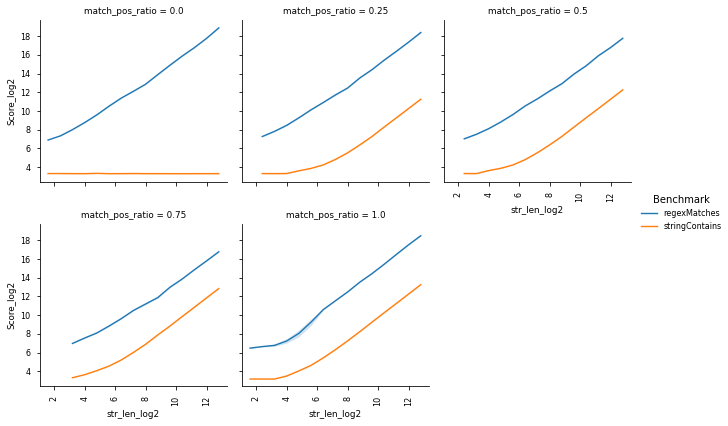

In [73]:
grid = sns.FacetGrid(df_float, col = "match_pos_ratio", hue = "Benchmark", col_wrap=3)
grid.map(sns.lineplot, "str_len_log2", "Score_log2", err_style="band")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()

In [112]:
filter_matches = df["matches"] == True
df.loc[~filter_matches,:]

,Benchmark,Score,Score Error (99.9%),str_len,sample,match_pos_ratio,Score_int,matches
2,regexMatches,180.465795,3.090356,64,4,1,180,False
3,stringContains,16.341973,0.192998,64,4,1,16,False
8,regexMatches,44284.156060,36.746968,8192,8,1,44284,False
9,stringContains,1200.070529,5.764294,8192,8,1,1200,False
12,regexMatches,1493.614974,19.719019,256,2,1,1494,False
...,...,...,...,...,...,...,...,...
2087,stringContains,1207.992415,2.275585,8192,5,1,1208,False
2094,regexMatches,88.692293,0.908595,4,7,1,89,False
2095,stringContains,8.976871,0.006926,4,7,1,9,False
2100,regexMatches,439.012287,1.298146,64,9,1,439,False


In [123]:
formula = 'Score ~ Benchmark + str_len + match_pos_ratio'
t = sm.stats.anova_lm(ols(formula, data = df.loc[filter_matches,:]).fit(), typ = 3)
t

,sum_sq,df,F,PR(>F)
Intercept,1.239516e+11,1.0,51.895835,8.900807e-13
Benchmark,7.221341e+11,1.0,302.341749,2.901839e-62
str_len,2.712349e+12,14.0,81.114373,1.275077e-175
match_pos_ratio,1.516629e+11,3.0,21.165975,1.882939e-13
Residual,3.900371e+12,1633.0,NaN,NaN


In [124]:
t.to_latex(index=True)

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &        sum\\_sq &      df &           F &         PR(>F) \\\\\n\\midrule\nIntercept       &  1.239516e+11 &     1.0 &   51.895835 &   8.900807e-13 \\\\\nBenchmark       &  7.221341e+11 &     1.0 &  302.341749 &   2.901839e-62 \\\\\nstr\\_len         &  2.712349e+12 &    14.0 &   81.114373 &  1.275077e-175 \\\\\nmatch\\_pos\\_ratio &  1.516629e+11 &     3.0 &   21.165975 &   1.882939e-13 \\\\\nResidual        &  3.900371e+12 &  1633.0 &         NaN &            NaN \\\\\n\\bottomrule\n\\end{tabular}\n'

In [125]:
formula = 'Score ~ Benchmark + str_len'
t = sm.stats.anova_lm(ols(formula, data = df.loc[~filter_matches,:]).fit(), typ = 3)

In [126]:
t.to_latex(index=True)

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &        sum\\_sq &     df &           F &        PR(>F) \\\\\n\\midrule\nIntercept &  2.031840e+10 &    1.0 &    8.521396 &  3.692595e-03 \\\\\nBenchmark &  2.582339e+11 &    1.0 &  108.301534 &  8.587257e-23 \\\\\nstr\\_len   &  1.149718e+12 &   14.0 &   34.441693 &  1.337589e-61 \\\\\nResidual  &  1.034829e+12 &  434.0 &         NaN &           NaN \\\\\n\\bottomrule\n\\end{tabular}\n'

In [143]:
for k, groups in df.groupby(["str_len","match_pos_ratio"]):
    print(k, len(groups['sample'])//2, groups.shape)

('1024', '0') 15 (30, 8)
('1024', '0.25') 15 (30, 8)
('1024', '0.5') 15 (30, 8)
('1024', '0.75') 15 (30, 8)
('1024', '1') 15 (30, 8)
('128', '0') 15 (30, 8)
('128', '0.25') 15 (30, 8)
('128', '0.5') 15 (30, 8)
('128', '0.75') 15 (30, 8)
('128', '1') 15 (30, 8)
('16', '0') 15 (30, 8)
('16', '0.25') 15 (30, 8)
('16', '0.5') 15 (30, 8)
('16', '0.75') 15 (30, 8)
('16', '1') 15 (30, 8)
('16384', '0') 15 (30, 8)
('16384', '0.25') 15 (30, 8)
('16384', '0.5') 15 (30, 8)
('16384', '0.75') 15 (30, 8)
('16384', '1') 15 (30, 8)
('2048', '0') 15 (30, 8)
('2048', '0.25') 15 (30, 8)
('2048', '0.5') 15 (30, 8)
('2048', '0.75') 15 (30, 8)
('2048', '1') 15 (30, 8)
('256', '0') 15 (30, 8)
('256', '0.25') 15 (30, 8)
('256', '0.5') 15 (30, 8)
('256', '0.75') 15 (30, 8)
('256', '1') 15 (30, 8)
('32', '0') 15 (30, 8)
('32', '0.25') 15 (30, 8)
('32', '0.5') 15 (30, 8)
('32', '0.75') 15 (30, 8)
('32', '1') 15 (30, 8)
('32768', '0') 15 (30, 8)
('32768', '0.25') 15 (30, 8)
('32768', '0.5') 15 (30, 8)
('32768', '

In [131]:
df['str_len'].value_counts()

128      150
2048     150
512      150
1024     150
16384    150
8192     150
4096     150
65536    150
32       150
16       150
32768    150
256      150
64       150
8        120
4         32
Name: str_len, dtype: int64

In [132]:
df.shape

(2102, 8)

In [135]:
75*14+60+16

1126

In [134]:
2102//2

1051

In [136]:
df['str_len'].value_counts().sum()

2102

In [137]:
1051

1051

In [140]:
for k, g in df.groupby("match_pos_ratio"):
    print(k,len(g['sample'])//2)

0 211
0.25 210
0.5 210
0.75 195
1 225


In [166]:
df_nonmatching = df_float.loc[~filter_matches,:]
df_nonmatching

,Benchmark,Score,Score Error (99.9%),str_len,sample,match_pos_ratio,Score_int,matches,Score_log2,str_len_log2
2,regexMatches,180.465795,3.090356,64,4,1.0,180,False,7.495582,6.0
3,stringContains,16.341973,0.192998,64,4,1.0,16,False,4.030510,6.0
8,regexMatches,44284.156060,36.746968,8192,8,1.0,44284,False,15.434503,13.0
9,stringContains,1200.070529,5.764294,8192,8,1.0,1200,False,10.228903,13.0
12,regexMatches,1493.614974,19.719019,256,2,1.0,1494,False,10.544593,8.0
...,...,...,...,...,...,...,...,...,...,...
2087,stringContains,1207.992415,2.275585,8192,5,1.0,1208,False,10.238396,13.0
2094,regexMatches,88.692293,0.908595,4,7,1.0,89,False,6.470737,2.0
2095,stringContains,8.976871,0.006926,4,7,1.0,9,False,3.166213,2.0
2100,regexMatches,439.012287,1.298146,64,9,1.0,439,False,8.778118,6.0


In [157]:
df_nonmatching.columns

Index(['Benchmark', 'Score', 'Score Error (99.9%)', 'str_len', 'sample',
       'match_pos_ratio', 'Score_int', 'matches', 'Score_log2',
       'str_len_log2'],
      dtype='object')

(0.0, 20.0)

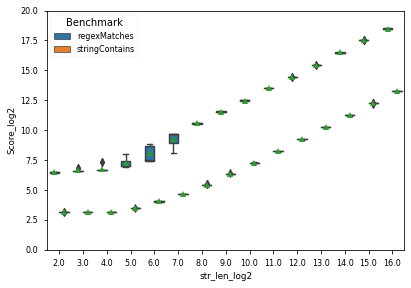

In [160]:
ax = sns.boxplot(x="str_len_log2", y="Score_log2",
            hue="Benchmark", 
            data=df_nonmatching, showmeans=True)
ax.set_ylim(0,20)

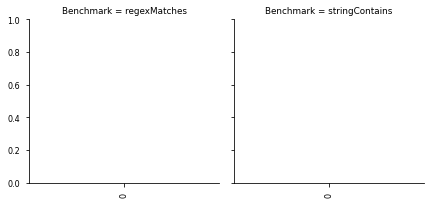

In [172]:
grid = sns.FacetGrid(df_nonmatching, col = "Benchmark", col_wrap=2)
grid.map(sns.boxplot, x="str_len_log2", y="Score")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()

In [190]:
df_nonmatching = df_float.loc[df_float['matches'] == False,:]

In [193]:
df_nonmatching_regex = df_nonmatching.loc[df_nonmatching['Benchmark'] == "regexMatches",:] # & df['Benchmark'] == "regexMatches",:]

In [194]:
df_nonmatching_string = df_nonmatching.loc[df_nonmatching['Benchmark'] != "regexMatches",:] # & df['Benchmark'] == "regexMatches",:]

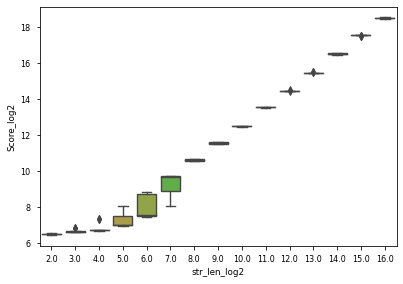

In [197]:
# fig, axes = plt.subplots(1, 2)
ax = sns.boxplot(x="str_len_log2", y="Score_log2", data=df_nonmatching_regex) #ax=axes[0, 0])
# ax = sns.boxplot(x="str_len", y="Score", data=df.loc[~filter_matches & df['Benchmark'] != "regexMatches",:], orient='v', ax=axes[0, 1])

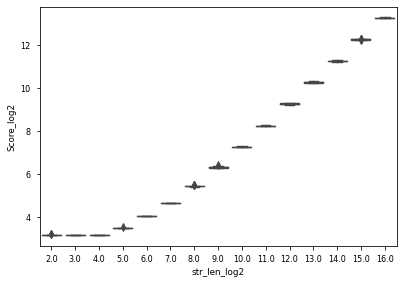

In [198]:
ax = sns.boxplot(x="str_len_log2", y="Score_log2", data=df_nonmatching_string) 

In [ ]:
grid = sns.FacetGrid(df_float, col = "match_pos_ratio", hue = "Benchmark", col_wrap=3)
grid.map(sns.lineplot, "str_len_log2", "Score_log2", err_style='bars', estimator='mean', ci="sd")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()

In [263]:
data = []
for k, g in df_nonmatching_regex.groupby("str_len"):
    data.append([k, g['Score'].std(), g['Score'].mean(), "regexMatches"])
for k, g in df_nonmatching_string.groupby("str_len"):
    data.append([k, g['Score'].std(), g['Score'].mean(), "stringContains"])

In [268]:
df_dev = pd.DataFrame(np.array(data))

In [269]:
df_dev.columns = ["str_len", "standard deviation", "average", "Benchmark"]
df_dev = df_dev.astype({"str_len":"int", "standard deviation":"float", "average":"float"})
df_dev["str_len_log2"] = df_dev['str_len'].apply(lambda x: math.log2(x))
df_dev['relative std'] = df_dev['standard deviation'] / df_dev['average']
print(df_dev.dtypes)
df_dev

str_len                 int64
standard deviation    float64
average               float64
Benchmark              object
str_len_log2          float64
relative std          float64
dtype: object


,str_len,standard deviation,average,Benchmark,str_len_log2,relative std
0,4,1.522209,88.647336,regexMatches,2.0,0.017172
1,8,5.548521,99.666285,regexMatches,3.0,0.055671
2,16,19.420968,109.996306,regexMatches,4.0,0.176560
3,32,56.181740,158.177112,regexMatches,5.0,0.355182
4,64,126.769050,289.936231,regexMatches,6.0,0.437231
5,128,250.635061,671.826947,regexMatches,7.0,0.373065
6,256,42.594046,1538.896562,regexMatches,8.0,0.027678
7,512,69.742575,2970.439051,regexMatches,9.0,0.023479
8,1024,66.768865,5693.725482,regexMatches,10.0,0.011727
9,2048,92.777874,11803.896797,regexMatches,11.0,0.007860


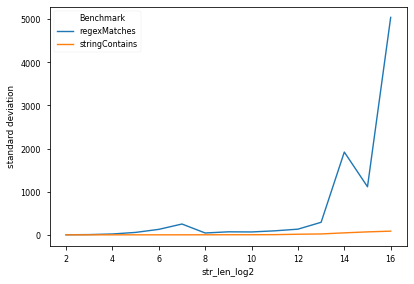

In [271]:
# df_dev.plot(by="Benchmark", x="str_len", y="standard deviation")
sns.lineplot(data=df_dev, x="str_len_log2", y="standard deviation", hue="Benchmark")

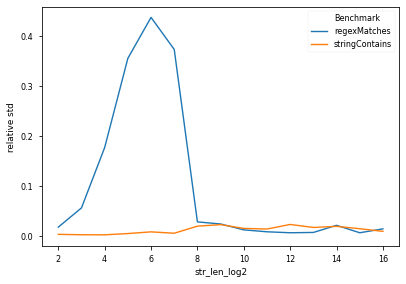

In [272]:
sns.lineplot(data=df_dev, x="str_len_log2", y="relative std", hue="Benchmark")

In [281]:
df_matching = df_float.loc[df_float['matches'] == True,:]
data = []
for k, g in df_matching.loc[df_matching['Benchmark']=="regexMatches",:].groupby("str_len"):
    data.append([k, g['Score'].std(), g['Score'].mean(), "regexMatches"])
for k, g in df_matching.loc[df_matching['Benchmark']=="stringContains",:].groupby("str_len"):
    data.append([k, g['Score'].std(), g['Score'].mean(), "stringContains"])
df_dev_m = pd.DataFrame(np.array(data))

In [282]:
df_dev_m.columns = ["str_len","standard deviation", "average", "Benchmark"]
df_dev_m = df_dev_m.astype({"str_len":"int", "standard deviation":"float", "average":"float"})
df_dev_m["str_len_log2"] = df_dev_m['str_len'].apply(lambda x: math.log2(x))
df_dev_m['relative std'] = df_dev_m['standard deviation'] / df_dev_m['average']
print(df_dev_m.dtypes)
df_dev_m

str_len                 int64
standard deviation    float64
average               float64
Benchmark              object
str_len_log2          float64
relative std          float64
dtype: object


,str_len,standard deviation,average,Benchmark,str_len_log2,relative std
0,4,NaN,119.129235,regexMatches,2.0,NaN
1,8,13.898921,149.004205,regexMatches,3.0,0.093279
2,16,50.247769,198.377151,regexMatches,4.0,0.253294
3,32,92.765335,313.373051,regexMatches,5.0,0.296022
4,64,188.028156,530.303728,regexMatches,6.0,0.354567
5,128,381.451064,959.784329,regexMatches,7.0,0.397434
6,256,689.267041,1719.841419,regexMatches,8.0,0.400774
7,512,1115.643765,2946.222349,regexMatches,9.0,0.378669
8,1024,1882.718318,4998.020717,regexMatches,10.0,0.376693
9,2048,4380.132181,9670.639527,regexMatches,11.0,0.452931


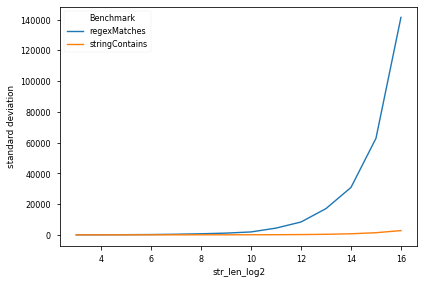

In [251]:
sns.lineplot(data=df_dev_m, x="str_len_log2", y="standard deviation", hue="Benchmark")

In [283]:
df_dev["matches"] = False
df_dev_m["matches"] = True
df_dev_comb = pd.concat([df_dev, df_dev_m])
df_dev_comb

,str_len,standard deviation,average,Benchmark,str_len_log2,relative std,matches
0,4,1.522209,88.647336,regexMatches,2.0,0.017172,False
1,8,5.548521,99.666285,regexMatches,3.0,0.055671,False
2,16,19.420968,109.996306,regexMatches,4.0,0.176560,False
3,32,56.181740,158.177112,regexMatches,5.0,0.355182,False
4,64,126.769050,289.936231,regexMatches,6.0,0.437231,False
5,128,250.635061,671.826947,regexMatches,7.0,0.373065,False
6,256,42.594046,1538.896562,regexMatches,8.0,0.027678,False
7,512,69.742575,2970.439051,regexMatches,9.0,0.023479,False
8,1024,66.768865,5693.725482,regexMatches,10.0,0.011727,False
9,2048,92.777874,11803.896797,regexMatches,11.0,0.007860,False


In [284]:
df_dev_comb["std_log2"] = df_dev_comb['standard deviation'].apply(lambda x: math.log2(x))

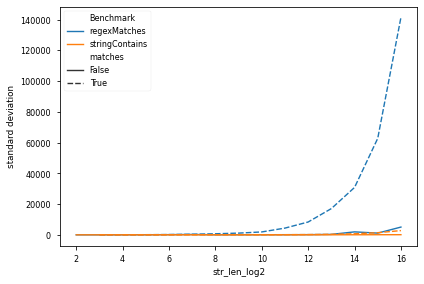

In [285]:
sns.lineplot(data=df_dev_comb, x="str_len_log2", y="standard deviation", hue="Benchmark", style = "matches")

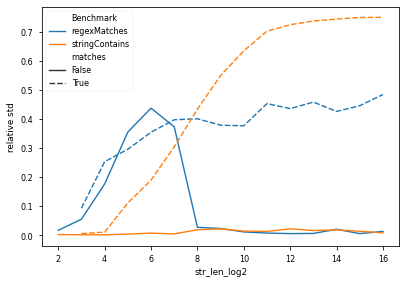

In [286]:
sns.lineplot(data=df_dev_comb, x="str_len_log2", y="relative std", hue="Benchmark", style = "matches")

In [308]:
data = []
for k, g in df_float.groupby(["str_len","match_pos_ratio","Benchmark"]):
    data.append([*k, g.shape, g['Score'].std(), g['Score'].mean()])
df_stat = pd.DataFrame(np.array(data))
df_stat.columns = ["str_len","match_pos_ratio","Benchmark","shape", "std", "average"]
print(df_stat.shape)
df_stat

(142, 6)


,str_len,match_pos_ratio,Benchmark,shape,std,average
0,4,0,regexMatches,"(1, 10)",NaN,119.129
1,4,0,stringContains,"(1, 10)",NaN,9.92694
2,4,1,regexMatches,"(15, 10)",1.52221,88.6473
3,4,1,stringContains,"(15, 10)",0.0244241,8.98458
4,8,0,regexMatches,"(15, 10)",4.76484,161.815
...,...,...,...,...,...,...
137,65536,0.5,stringContains,"(15, 10)",66.9274,4900.57
138,65536,0.75,regexMatches,"(15, 10)",738.841,111961
139,65536,0.75,stringContains,"(15, 10)",62.2935,7328.98
140,65536,1,regexMatches,"(15, 10)",5043.22,367842


In [309]:
df_stat = df_stat.astype({"str_len":"int", "match_pos_ratio":"float", "std":"float", "average":"float"})
df_stat["str_len_log2"] = df_stat['str_len'].apply(lambda x: math.log2(x))
df_stat['relative std'] = df_stat['std'] / df_stat['average']
df_stat['matches'] = df_stat['match_pos_ratio'] < 1
print(df_stat.dtypes)
df_stat

str_len              int64
match_pos_ratio    float64
Benchmark           object
shape               object
std                float64
average            float64
str_len_log2       float64
relative std       float64
matches               bool
dtype: object


,str_len,match_pos_ratio,Benchmark,shape,std,average,str_len_log2,relative std,matches
0,4,0.00,regexMatches,"(1, 10)",NaN,119.129235,2.0,NaN,True
1,4,0.00,stringContains,"(1, 10)",NaN,9.926939,2.0,NaN,True
2,4,1.00,regexMatches,"(15, 10)",1.522209,88.647336,2.0,0.017172,False
3,4,1.00,stringContains,"(15, 10)",0.024424,8.984581,2.0,0.002718,False
4,8,0.00,regexMatches,"(15, 10)",4.764841,161.814613,3.0,0.029446,True
...,...,...,...,...,...,...,...,...,...
137,65536,0.50,stringContains,"(15, 10)",66.927353,4900.572547,16.0,0.013657,True
138,65536,0.75,regexMatches,"(15, 10)",738.841240,111961.339379,16.0,0.006599,True
139,65536,0.75,stringContains,"(15, 10)",62.293471,7328.975043,16.0,0.008500,True
140,65536,1.00,regexMatches,"(15, 10)",5043.217057,367842.409897,16.0,0.013710,False


In [319]:
df_stat["std_log2"] = df_stat['std'].apply(lambda x: math.log2(x))

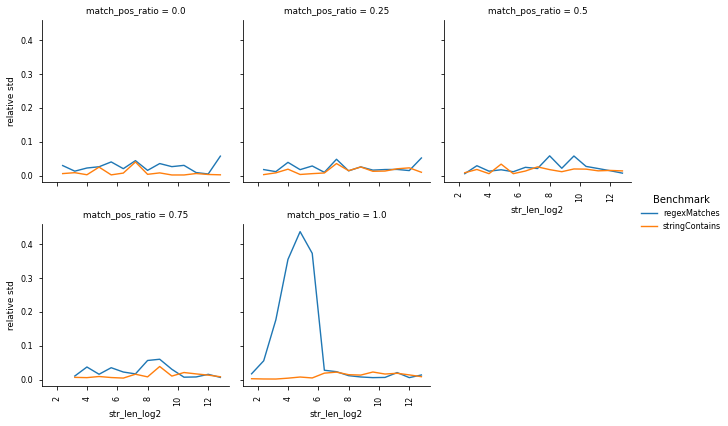

In [305]:
grid = sns.FacetGrid(df_stat, col = "match_pos_ratio", hue = "Benchmark", col_wrap=3)
grid.map(sns.lineplot, "str_len_log2", "relative std")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()

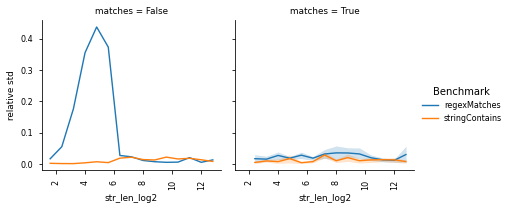

In [310]:
grid = sns.FacetGrid(df_stat, col = "matches", hue = "Benchmark", col_wrap=2)
grid.map(sns.lineplot, "str_len_log2", "relative std")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()

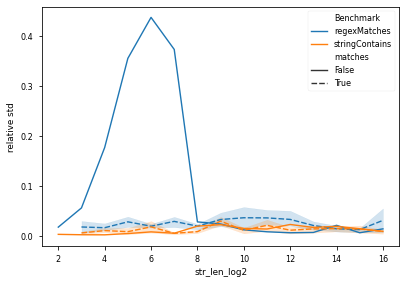

In [315]:
sns.lineplot(data=df_stat, x="str_len_log2", y="relative std", hue="Benchmark", style="matches", err_style="band")

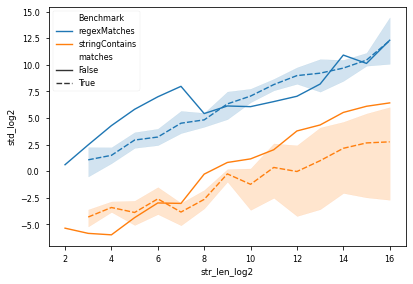

In [320]:
sns.lineplot(data=df_stat, x="str_len_log2", y="std_log2", hue="Benchmark", style="matches", err_style="band")

In [14]:
df_float.dtypes

Benchmark               object
Score                  float64
Score Error (99.9%)    float64
str_len                  int64
sample                   int64
match_pos_ratio        float64
Score_int                int64
matches                   bool
standard deviation     float64
dtype: object

In [15]:
df_float['relative std'] = df_float['standard deviation'] / df_float['Score']

In [16]:
df_float["std_log2"] = df_float['standard deviation'].apply(lambda x: math.log2(x))

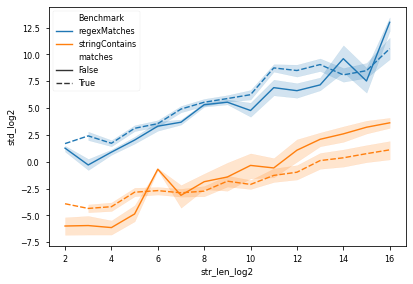

In [20]:
sns.lineplot(data=df_float, x="str_len_log2", y="std_log2", hue="Benchmark", style="matches", err_style="band")

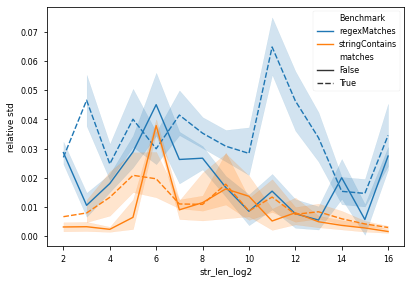

In [21]:
sns.lineplot(data=df_float, x="str_len_log2", y="relative std", hue="Benchmark", style="matches", err_style="band")

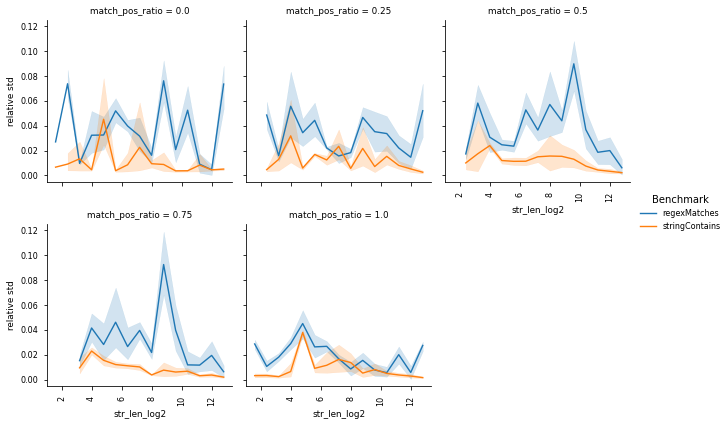

In [22]:
grid = sns.FacetGrid(df_float, col = "match_pos_ratio", hue = "Benchmark", col_wrap=3)
grid.map(sns.lineplot, "str_len_log2", "relative std")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()

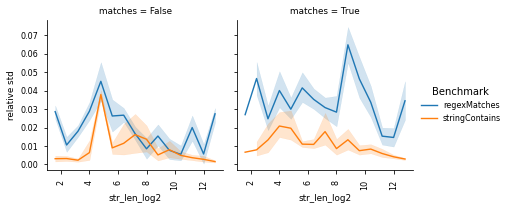

In [23]:
grid = sns.FacetGrid(df_float, col = "matches", hue = "Benchmark", col_wrap=2)
grid.map(sns.lineplot, "str_len_log2", "relative std")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()

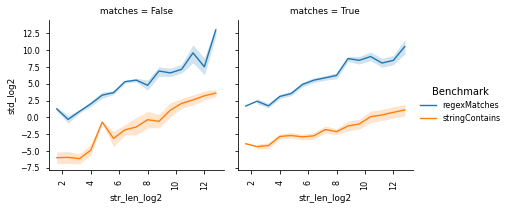

In [24]:
grid = sns.FacetGrid(df_float, col = "matches", hue = "Benchmark", col_wrap=2)
grid.map(sns.lineplot, "str_len_log2", "std_log2")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()

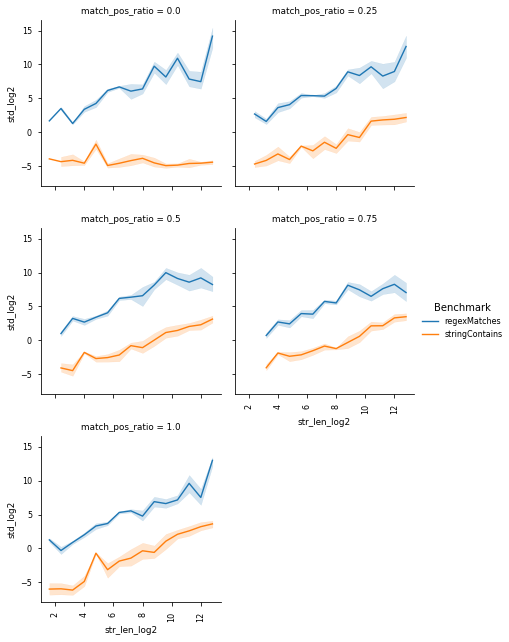

In [25]:
grid = sns.FacetGrid(df_float, col = "match_pos_ratio", hue = "Benchmark", col_wrap=2)
grid.map(sns.lineplot, "str_len_log2", "std_log2")
grid.add_legend()
grid.set_xticklabels(rotation=90)
plt.show()

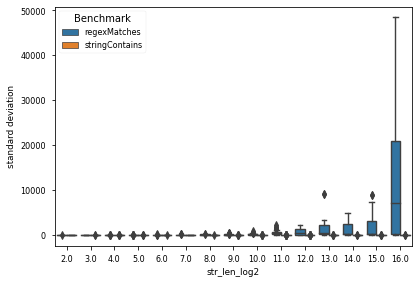

In [26]:
sns.boxplot(data = df_float, x="str_len_log2", y="standard deviation", hue = "Benchmark")

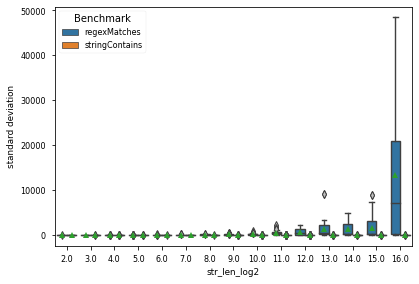

In [27]:
flierprops = dict(markerfacecolor='0.75', markersize=5,
              linestyle='none')
sns.boxplot(data = df_float, x="str_len_log2", y="standard deviation", hue = "Benchmark", showmeans = True, flierprops=flierprops)

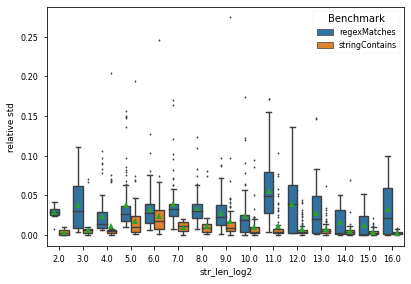

In [28]:
flierprops = dict(markerfacecolor='0.75', markersize=1,
              linestyle='none')
sns.boxplot(data = df_float, x="str_len_log2", y="relative std", hue = "Benchmark", showmeans = True, flierprops=flierprops)

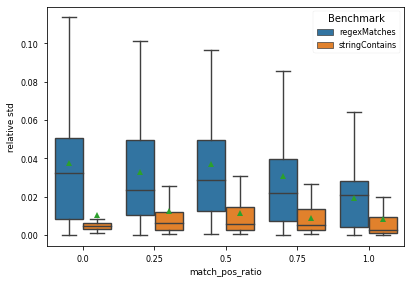

In [29]:
sns.boxplot(data = df_float, x="match_pos_ratio", y="relative std", hue = "Benchmark", showmeans = True, showfliers=False)

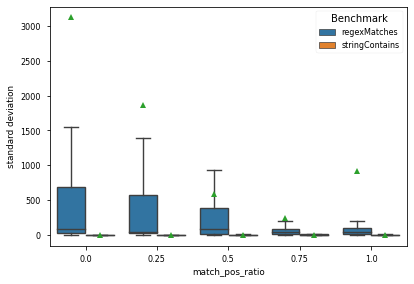

In [30]:
sns.boxplot(data = df_float, x="match_pos_ratio", y="standard deviation", hue = "Benchmark", showmeans = True, showfliers=False)

In [31]:
df_float

,Benchmark,Score,Score Error (99.9%),str_len,sample,match_pos_ratio,Score_int,matches,standard deviation,relative std,std_log2,Score_log2,str_len_log2
0,regexMatches,112841.700862,40.775134,32768,4,0.50,112842,True,120.226472,0.001065,6.909611,16.783941,15.0
1,stringContains,2426.099840,0.758018,32768,4,0.50,2426,True,2.234993,0.000921,1.160270,11.244423,15.0
2,regexMatches,180.465795,3.090356,64,4,1.00,180,False,9.112030,0.050492,3.187772,7.495582,6.0
3,stringContains,16.341973,0.192998,64,4,1.00,16,False,0.569051,0.034821,-0.813371,4.030510,6.0
4,regexMatches,62548.265615,27.063956,16384,1,0.50,62548,True,79.798707,0.001276,6.318293,15.932682,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097,stringContains,36.811980,0.148843,256,1,0.75,37,True,0.438879,0.011922,-1.188106,5.202103,8.0
2098,regexMatches,112155.754831,18.360643,32768,9,0.50,112156,True,54.136818,0.000483,5.758538,16.775144,15.0
2099,stringContains,2478.434663,2.755485,32768,9,0.50,2478,True,8.124639,0.003278,3.022304,11.275214,15.0
2100,regexMatches,439.012287,1.298146,64,9,1.00,439,False,3.827639,0.008719,1.936455,8.778118,6.0


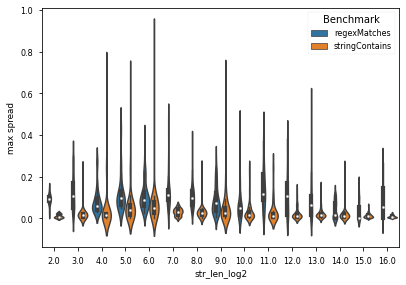

In [74]:
sns.violinplot(data = df_float, x = "str_len_log2", y = "max spread", hue = "Benchmark")

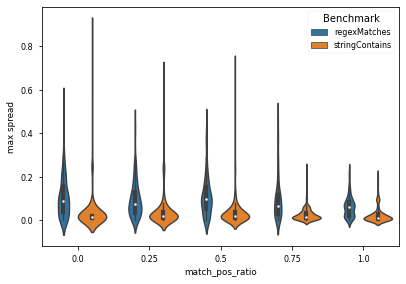

In [75]:
sns.violinplot(data = df_float, x = "match_pos_ratio", y = "max spread", hue = "Benchmark")

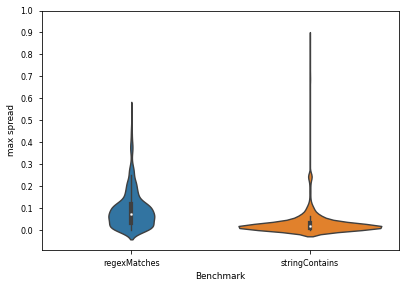

In [89]:
ax = sns.violinplot(data = df_float, x = "Benchmark", y = "max spread")
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

/Users/pw/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
UsageError: Line magic function `%grid.xticks(np.arange(min(x),` not found.


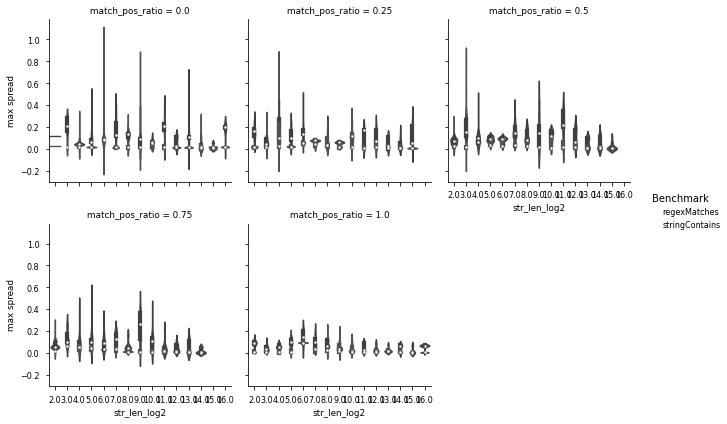

In [77]:
grid = sns.FacetGrid(df_float, col = "match_pos_ratio", hue = "Benchmark", col_wrap=3)
grid.map(sns.violinplot, "str_len_log2", "max spread")
grid.add_legend()
%grid.xticks(np.arange(min(x), max(x)+1, 1.0))
grid.set_xticklabels(step = 0.1, rotation=90)
plt.show()